 # **GROUP 27 - DL ASSIGNMENT_1** 
 
---


---
> **Members** -<br> 
1. V.A.S.Abhinav   - 2018B1A70979G 
2. Anirudh Nagaraj  - 2018A7PS0216G
3. Tushar Gupta    - 2019A4PS0046G

> **Contributions** -<br> 

Abhinav - Backbone Code for preloading dataset & designing of shallow networks

Anirudh -Designing all deep models used in the second ablation study of difference due to number of skip net blocks

Tushar - Designing all deep models used in the first ablation study of difference due to number of skipped layers in skip connections 










**Conclusion**- Skip Connections help to overcome vanishing gradient problem and overfitting, performance degradation due to deeper layers ,as they provide a mechanism to retain the earlier layer features


Description of code

Our code written in a obeject oriented way.There are 3 classes which we have created 
1. Data - This loads the Dataset, and stores the data in distributed form of training set,validation set and test set
2. Preprocessing - All the preprocessing operations carried out on the loaded data
3. Model Optimizer - stores all data,hyperparamters and model type used for training and evaluation; Two metrics were calculated validation accuracy and test accuracy when each model is trained to measure the performance 


**Key Terms**
We have named our models in certain way , here is a brief description of each model
1. Plain_nets_short - 5 layer network with no skip connections
2. Skip_nets_add_short - 5 layer network with add type skip connection between layer 4 and layer 1
3. Skip_nets_concat_short - 5layer network with concat type skip connection between layer 4 and layer 1

All networks below are 15 layered
4. Plain_nets_long  - Deep MLPs network with no skip connections
5. Skip_nets_add_4_14 - add skip connection between layer 4 and 14
6. Skip_nets_add_7_14 - add skip connection between layer 7 and 14
7. Skip_nets_add_11_14 - add skip connection between layer 11 and 14
8. Skip_nets_concat_4_14 - concat skip connection between layer 4 and 14
9. Skip_nets_concat_7_14 - concat skip connection between layer 7 and 14
10. Skip_nets_concat_11_14 - concat skip connection between layer 11 and 14
11. Skip_nets_add_4_7     - add skip connection between layer 4 and 14
12. Skip_nets_add_4_7_11  - add skip net blocks between (4,7) and (7,11)
13. Skip_nets_add_4_7_11_14 - add skip net blocks between (4,7),(7,11) and ((11,14)
14. Skip_nets_concat_4_7    - concat skip net blocks between (4,7)
15. Skip_nets_concat_4_7_11  - concat skip net blocks between (4,7)and (7,11)
16. Skip_nets_concat_4_7_11_14 - concat skip net blocks between (4,7),(7,11) and (11,14)





In [1]:
!pip install torchmetrics

     |████████████████████████████████| 282 kB 4.1 MB/s 


In [2]:
#all imports neccesary for code
import numpy as np
import gc
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from torchmetrics import Accuracy



## Custom class for Preprocessing of dataset

In [3]:
class Preprocessing:
    '''
    This class handles all the preprocessing operations required to be done so as create a final set of data of the model which would be used for training and testing

    Steps:
    1>Flattening data
    2>Normalizing data
    3>Creating a train and validation split
    '''

    @staticmethod
    def train_val_split(X,y):
        '''
        Splits data into train and val set based on stratified sampling
        '''
        ss = StratifiedShuffleSplit(n_splits = 1,test_size=0.2,random_state=0)
        for train_index,val_index in ss.split(X,y):
            X_train,Y_train = X[train_index],y[train_index]
            X_val,Y_val     = X[val_index],y[val_index]

        return X_train,X_val,Y_train,Y_val

    @staticmethod
    def flatten_data(X):
        '''
        flattens out image pixels in a 1D array per instance
        '''
        return np.reshape(X,(X.shape[0],-1))

    @staticmethod
    def normalize_data(X):
        '''
        scales pixel values to be in the range 0-1
        '''
        return X/255


  




## Custom class for importing dataset

In [4]:

#loads data from server based on argument given
class Data:
    '''
    This class creates an instance of the dataset object which stores all the information related to dataset
    '''

    def __init__(self,name):
        if name=="CIFAR":
            self.name = name
            self.training_data = datasets.CIFAR10(root="CIFAR",train =True,download =True,) 
            self.test_data     = datasets.CIFAR10(root="CIFAR",train=False,download =True,)

        if name=="MNIST":
            self.name = name
            self.training_data = datasets.MNIST(root="MNIST",train =True,download =True) 
            self.test_data     = datasets.MNIST(root="MNIST",train=False,download =True)

        self.X_train = None
        self.X_val   = None
        self.Y_train = None
        self.Y_val   = None
        
        if name == "CIFAR":
            self.X_test  = torch.from_numpy(Preprocessing.flatten_data(self.test_data.data),).float() 
        
        else:
            self.X_test  =torch.reshape(self.test_data.data,(self.test_data.data.shape[0],-1)).float() #MNIST dataset by default gives a tensor

        self.Y_test  = torch.tensor(self.test_data.targets)

    def preprocess(self):
        '''
        carry out all preprocessing steps in one go
        '''
        X = Preprocessing.flatten_data(self.training_data.data)
        X = Preprocessing.normalize_data(X)
        if self.name == "CIFAR": 
            self.X_train,self.X_val,self.Y_train,self.Y_val = Preprocessing.train_val_split(X,np.array(self.training_data.targets))
            self.X_train,self.X_val,self.Y_train,self.Y_val = torch.from_numpy(self.X_train),torch.from_numpy(self.X_val),torch.from_numpy(self.Y_train),torch.from_numpy(self.Y_val)
        
        else:
            self.X_train,self.X_val,self.Y_train,self.Y_val = Preprocessing.train_val_split(X,np.array(self.training_data.targets))#Mnist dataset by default is of Tensor type
            self.Y_train = torch.from_numpy(self.Y_train)
            self.Y_val   = torch.from_numpy(self.Y_val)


        


## Creating custom models for training

Here we describe all our custom models we will be using in our assignment

In [16]:

class Plain_nets_short(nn.Module):

    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
       
        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)
        
        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)


        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        
        self.layer5     = nn.Linear(50,10)

    def forward(self,x):
        x = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        x = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(x))))
        x = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(x))))
        x = self.layer4_act(self.layer4_bn(self.layer4(x)))
        out = self.layer5(x)

        return out

class Skip_nets_add_short(nn.Module):
    

    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
        


        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)

        



        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)




        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()


        self.layer5 = nn.Linear(50,10)

    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2)))) 
        layer4 = self.layer4_act(self.layer4_bn(self.layer4(layer3)+layer1)) 
        out = self.layer5(layer4)


        return out

class Skip_nets_concat_short(nn.Module):
    

    def __init__(self,input_dims,dp = 0.2):
        super().__init__()
        self.layer1 = nn.Linear(input_dims,50)
        self.layer1_bn = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)

        self.layer2 = nn.Linear(50,50) 
        self.layer2_bn = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp = nn.Dropout(dp)

        self.layer3 = nn.Linear(50,50)
        self.layer3_bn = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp = nn.Dropout(dp)
        

        self.layer4 = nn.Linear(50,50)
        self.layer4_bn = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp = nn.Dropout(dp)

        self.layer5 = nn.Linear(100,10)
        

        

    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        
        concatenated = torch.cat([layer1,layer4],dim=1)

        out = self.layer5(concatenated) 

            
        return out


class Plain_nets_long(nn.Module):

    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
       
        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)
        
        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)


        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp = nn.Dropout(dp)
        
        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp  = nn.Dropout(dp)
       
        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
        
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)


        self.layer8     = nn.Linear(50,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)
        
        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
       
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
        
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)


        self.layer12     = nn.Linear(50,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)
        
        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        
        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()
        
        self.layer15     = nn.Linear(50,10)
        
    def forward(self,x):
        x = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        x = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(x))))
        x = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(x))))
        x = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(x))))
        x = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(x))))
        x = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(x))))
        x = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(x))))
        x = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(x))))
        x = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(x))))
        x = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(x))))
        x = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(x))))
        x = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(x))))
        x = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(x))))
        x = self.layer14_act(self.layer14_bn(self.layer14(x)))
        
        out = self.layer15(x)

        return out

class Skip_nets_add_4_14(nn.Module):
    
    
    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
        


        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)

        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)
        
        
        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp  = nn.Dropout(dp)


        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp = nn.Dropout(dp)

        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
       
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)
        
        self.layer8     = nn.Linear(50,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)


        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
        
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
       
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)
        
        self.layer12     = nn.Linear(50,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)

        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        

        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()


        self.layer15 = nn.Linear(50,10)

    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))
        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6))))
        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(layer7))))
        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))
        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10))))
        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(layer11))))
        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))
     
        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13)+layer4)) 
        out = self.layer15(layer14)


        return out

class Skip_nets_add_7_14(nn.Module):
    
    
    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
        


        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)

        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)
        
        
        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp  = nn.Dropout(dp)


        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp = nn.Dropout(dp)

        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
       
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)
        
        self.layer8     = nn.Linear(50,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)


        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
        
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
       
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)
        
        self.layer12     = nn.Linear(50,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)

        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        

        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()


        self.layer15 = nn.Linear(50,10)

    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))
        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6))))
        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(layer7))))
        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))
        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10))))
        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(layer11))))
        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))
     
        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13)+layer7)) 
        out = self.layer15(layer14)


        return out

class Skip_nets_add_11_14(nn.Module):
    
    
    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
        


        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)

        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)
        
        
        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp  = nn.Dropout(dp)


        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp = nn.Dropout(dp)
        
        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
       
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)
        
        self.layer8     = nn.Linear(50,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)


        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
        
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
       
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)
        
        self.layer12     = nn.Linear(50,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)

        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        

        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()


        self.layer15 = nn.Linear(50,10)

    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))
        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6))))
        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(layer7))))
        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))
        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10))))
        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(layer11))))
        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))
     
        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13)+layer11)) 
        out = self.layer15(layer14)


        return out


class Skip_nets_concat_4_14(nn.Module):

    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
       
        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)
        
        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)


        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp = nn.Dropout(dp)
        
        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp  = nn.Dropout(dp)
       
        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
        
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)


        self.layer8     = nn.Linear(50,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)
        
        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
       
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
        
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)


        self.layer12     = nn.Linear(50,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)
        
        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        
        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()
        
        self.layer15     = nn.Linear(100,10)
        
    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))
        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6))))
        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(layer7))))
        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))
        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10))))
        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(layer11))))
        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))
        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13)))

        concatenated  = torch.cat([layer4,layer14],dim=1)
        out = self.layer15(concatenated)

        return out

class Skip_nets_concat_7_14(nn.Module):

    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
       
        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)
        
        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)


        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp = nn.Dropout(dp)
        
        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp  = nn.Dropout(dp)
       
        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
        
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)


        self.layer8     = nn.Linear(50,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)
        
        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
       
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
        
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)


        self.layer12     = nn.Linear(50,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)
        
        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        
        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()
        
        self.layer15     = nn.Linear(100,10)
        
    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))
        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6))))
        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(layer7))))
        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))
        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10))))
        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(layer11))))
        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))
        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13)))
        
        concatenated  = torch.cat([layer7,layer14],dim=1)
        out = self.layer15(concatenated)

        return out

class Skip_nets_concat_11_14(nn.Module):

    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
       
        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)
        
        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)


        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp = nn.Dropout(dp)
        
        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp  = nn.Dropout(dp)
       
        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
        
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)


        self.layer8     = nn.Linear(50,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)
        
        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
       
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
        
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)


        self.layer12     = nn.Linear(50,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)
        
        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        
        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()
        
        self.layer15     = nn.Linear(100,10)
        
    def forward(self,x):
      
        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))
        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6))))
        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(layer7))))
        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))
        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10))))
        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(layer11))))
        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))
        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13)))

        concatenated  = torch.cat([layer11,layer14],dim=1)
        out = self.layer15(concatenated)

        return out

class Skip_nets_add_4_7(nn.Module): 
    
    
    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
        


        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)

        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)
        
        
        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp  = nn.Dropout(dp)


        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp = nn.Dropout(dp)

        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
       
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)
        
        self.layer8     = nn.Linear(50,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)


        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
        
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
       
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)
        
        self.layer12     = nn.Linear(50,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)

        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        

        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()


        self.layer15 = nn.Linear(50,10)

    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))

        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6) + layer4))) 

        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(layer7))))
        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))
        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10))))
        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(layer11))))
        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))
        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13))) 
        out = self.layer15(layer14)


        return out



class Skip_nets_add_4_7_11(nn.Module): 
    
    
    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
        


        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)

        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)
        
        
        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp  = nn.Dropout(dp)


        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp = nn.Dropout(dp)

        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
       
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)
        
        self.layer8     = nn.Linear(50,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)


        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
        
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
       
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)
        
        self.layer12     = nn.Linear(50,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)

        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        

        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()


        self.layer15 = nn.Linear(50,10)

    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))

        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6) + layer4))) 

        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(layer7))))
        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))

        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10) + layer7))) 

        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(layer11))))
        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))
        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13))) 
        out = self.layer15(layer14)


        return out





class Skip_nets_add_4_7_11_14(nn.Module): 
    
    
    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
        


        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)

        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)
        
        
        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp  = nn.Dropout(dp)


        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp = nn.Dropout(dp)

        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
       
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)
        
        self.layer8     = nn.Linear(50,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)


        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
        
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
       
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)
        
        self.layer12     = nn.Linear(50,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)

        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        

        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()


        self.layer15 = nn.Linear(50,10)

    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))

        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6) + layer4))) 

        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(layer7))))
        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))

        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10) + layer7))) 

        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(layer11))))
        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))

        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13) + layer11)) 

        out = self.layer15(layer14)


        return out
class Skip_nets_concat_4_7(nn.Module):
   
    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
       
        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)
        
        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)


        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp = nn.Dropout(dp)
        
        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp  = nn.Dropout(dp)
       
        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
        
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)


        self.layer8     = nn.Linear(100,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)
        
        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
       
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
        
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)


        self.layer12     = nn.Linear(50,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)
        
        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        
        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()
        
        self.layer15     = nn.Linear(50,10)
        
    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))
        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6))))

        concatenated  = torch.cat([layer4,layer7],dim=1)

        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(concatenated))))

        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))
        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10))))
        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(layer11))))
        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))
        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13)))

        out = self.layer15(layer14)

        return out




class Skip_nets_concat_4_7_11(nn.Module):
    
    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
       
        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)
        
        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)


        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp = nn.Dropout(dp)
        
        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp  = nn.Dropout(dp)
       
        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
        
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)


        self.layer8     = nn.Linear(100,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)
        
        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
       
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
        
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)


        self.layer12     = nn.Linear(100,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)
        
        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        
        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()
        
        self.layer15     = nn.Linear(50,10)
        
    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))
        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6))))

        concatenated  = torch.cat([layer4,layer7],dim=1)

        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(concatenated))))

        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))
        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10))))

        concatenated  = torch.cat([layer7,layer11],dim=1)

        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(concatenated))))

        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))
        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13)))

        out = self.layer15(layer14)

        return out




class Skip_nets_concat_4_7_11_14(nn.Module):
    
    def __init__(self,input_dims,dp=0.2):
        super().__init__()
        self.layer1     = nn.Linear(input_dims,50)
        self.layer1_bn  = nn.BatchNorm1d(50)
        self.layer1_act = nn.ReLU()
        self.layer1_dp  = nn.Dropout(dp)
       
        self.layer2     = nn.Linear(50,50)
        self.layer2_bn  = nn.BatchNorm1d(50)
        self.layer2_act = nn.ReLU()
        self.layer2_dp  = nn.Dropout(dp)
        
        self.layer3     = nn.Linear(50,50)
        self.layer3_bn  = nn.BatchNorm1d(50)
        self.layer3_act = nn.ReLU()
        self.layer3_dp  = nn.Dropout(dp)


        self.layer4     = nn.Linear(50,50)
        self.layer4_bn  = nn.BatchNorm1d(50)
        self.layer4_act = nn.ReLU()
        self.layer4_dp = nn.Dropout(dp)
        
        self.layer5     = nn.Linear(50,50)
        self.layer5_bn  = nn.BatchNorm1d(50)
        self.layer5_act = nn.ReLU()
        self.layer5_dp  = nn.Dropout(dp)
       
        self.layer6     = nn.Linear(50,50)
        self.layer6_bn  = nn.BatchNorm1d(50)
        self.layer6_act = nn.ReLU()
        self.layer6_dp  = nn.Dropout(dp)
        
        self.layer7     = nn.Linear(50,50)
        self.layer7_bn  = nn.BatchNorm1d(50)
        self.layer7_act = nn.ReLU()
        self.layer7_dp  = nn.Dropout(dp)


        self.layer8     = nn.Linear(100,50)
        self.layer8_bn  = nn.BatchNorm1d(50)
        self.layer8_act = nn.ReLU()
        self.layer8_dp  = nn.Dropout(dp)
        
        self.layer9     = nn.Linear(50,50)
        self.layer9_bn  = nn.BatchNorm1d(50)
        self.layer9_act = nn.ReLU()
        self.layer9_dp  = nn.Dropout(dp)
       
        self.layer10     = nn.Linear(50,50)
        self.layer10_bn  = nn.BatchNorm1d(50)
        self.layer10_act = nn.ReLU()
        self.layer10_dp  = nn.Dropout(dp)
        
        self.layer11     = nn.Linear(50,50)
        self.layer11_bn  = nn.BatchNorm1d(50)
        self.layer11_act = nn.ReLU()
        self.layer11_dp  = nn.Dropout(dp)


        self.layer12     = nn.Linear(100,50)
        self.layer12_bn  = nn.BatchNorm1d(50)
        self.layer12_act = nn.ReLU()
        self.layer12_dp  = nn.Dropout(dp)
        
        self.layer13     = nn.Linear(50,50)
        self.layer13_bn  = nn.BatchNorm1d(50)
        self.layer13_act = nn.ReLU()
        self.layer13_dp  = nn.Dropout(dp)
        
        self.layer14     = nn.Linear(50,50)
        self.layer14_bn  = nn.BatchNorm1d(50)
        self.layer14_act = nn.ReLU()
        
        self.layer15     = nn.Linear(100,10)
        
    def forward(self,x):

        layer1 = self.layer1_dp(self.layer1_act(self.layer1_bn(self.layer1(x))))
        layer2 = self.layer2_dp(self.layer2_act(self.layer2_bn(self.layer2(layer1))))
        layer3 = self.layer3_dp(self.layer3_act(self.layer3_bn(self.layer3(layer2))))
        layer4 = self.layer4_dp(self.layer4_act(self.layer4_bn(self.layer4(layer3))))
        layer5 = self.layer5_dp(self.layer5_act(self.layer5_bn(self.layer5(layer4))))
        layer6 = self.layer6_dp(self.layer6_act(self.layer6_bn(self.layer6(layer5))))
        layer7 = self.layer7_dp(self.layer7_act(self.layer7_bn(self.layer7(layer6))))

        concatenated  = torch.cat([layer4,layer7],dim=1)

        layer8 = self.layer8_dp(self.layer8_act(self.layer8_bn(self.layer8(concatenated))))

        layer9 = self.layer9_dp(self.layer9_act(self.layer9_bn(self.layer9(layer8))))
        layer10 = self.layer10_dp(self.layer10_act(self.layer10_bn(self.layer10(layer9))))
        layer11 = self.layer11_dp(self.layer11_act(self.layer11_bn(self.layer11(layer10))))

        concatenated  = torch.cat([layer7,layer11],dim=1)

        layer12 = self.layer12_dp(self.layer12_act(self.layer12_bn(self.layer12(concatenated))))

        layer13 = self.layer13_dp(self.layer13_act(self.layer13_bn(self.layer13(layer12))))
        layer14 = self.layer14_act(self.layer14_bn(self.layer14(layer13)))

        concatenated  = torch.cat([layer11,layer14],dim=1)

        out = self.layer15(concatenated)

        return out








In [6]:
class Model_Optimizer:
    '''
    This class will be responsible for training the model and calculating performance metrics,storing the best perfoming model hyperparameters
    '''

    def __init__(self,data,model,optimizer_name,epochs,learning_rate=0.01,batch_size =None):

        self.model = model
        self.network_type = self.model.__class__.__name__
        self.data_name = data.name
        self.data  = data
        self.EPOCHS = epochs
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name
        if batch_size == None:
            self.batch_size = self.data.X_train.shape[0]
        else:
            self.batch_size = batch_size
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_tracked_loss = []
        self.val_tracked_loss = []
        
        self.val_accuracy = None
        self.train_accuracy = None
        self.test_accuracy  = None
                

    def __repr__(self):

        print("Model Structure of type -",self.network_type)
        print("Optimizer: ",self.optimizer_name)
        print("Loss fn: ",self.loss_fn)
        print(f"Run for {self.EPOCHS} epochs")

        if self.test_accuracy == None:
            print("Model has not been evaluated yet")
        else:
            print(f"Validation accuracy: {self.val_accuracy}")
            print(f"Test accuracy: {self.test_accuracy}")

        return ""

    def train(self,display_loss = False,):

        '''
        Trains the model and saves the running loss
        '''
    
        #set gpu as computation device, move all tensors to gpu for computation
        if torch.cuda.is_available():
            self.model        = self.model.cuda()
            self.data.X_train = self.data.X_train.to('cuda:0',).float()
            self.data.X_val   = self.data.X_val.to('cuda:0').float()
            self.data.X_test  = self.data.X_test.to('cuda:0').float()
            self.data.Y_train = self.data.Y_train.to('cuda:0')
            self.data.Y_val   = self.data.Y_val.to('cuda:0')
            self.data.Y_test  = self.data.Y_test.to('cuda:0')

        else:
            self.model        = self.model.cpu()
            self.data.X_train = self.data.X_train.to('cpu',).float()
            self.data.X_val   = self.data.X_val.to('cpu').float()
            self.data.X_test  = self.data.X_test.to('cpu').float()
            self.data.Y_train = self.data.Y_train.to('cpu')
            self.data.Y_val   = self.data.Y_val.to('cpu')
            self.data.Y_test  = self.data.Y_test.to('cpu')

        


        #set model in training mode
        self.model.train()


        #setting up the optimzer
        if self.optimizer_name == "ADAM":
            optimizer = torch.optim.Adam(params = self.model.parameters(),lr = self.learning_rate)

        if self.optimizer_name == "SGD":
            optimizer = torch.optim.SGD(params = self.model.parameters(),lr = self.learning_rate)

        if self.optimizer_name == "RMS":
            optimizer = torch.optim.RMSprop(params =self.model.parameters(),lr = self.learning_rate)

        
        #creating batches of data
        no_of_batches = self.data.X_train.shape[0]//self.batch_size

        print(f"Training {self.network_type} on {self.data_name} plz wait")
       
        for epoch in range(self.EPOCHS):

            
            for mini_batch_no in range(no_of_batches+1):

                #Zero the gradients
                optimizer.zero_grad()

                output_train = self.model(self.data.X_train[mini_batch_no*self.batch_size : (mini_batch_no+1)*self.batch_size])
                train_loss = self.loss_fn(output_train,self.data.Y_train[mini_batch_no*self.batch_size : (mini_batch_no+1)*self.batch_size])
                

                train_loss.backward()#calculate gradients
                optimizer.step()#update weights 

            output_val = self.model(self.data.X_val)
            val_loss   = self.loss_fn(output_val,self.data.Y_val)

            output_train = self.model(self.data.X_train)
            train_loss   = self.loss_fn(output_train,self.data.Y_train)

            #track the loss per epoch
            self.train_tracked_loss.append(train_loss.item())
            self.val_tracked_loss.append(val_loss.item())



            if epoch % 10 == 0 and display_loss == True:
                print ("Epoch #",epoch)
                print("Training loss:",train_loss.item())
                print("Validation loss:",val_loss.item())
        

    def evaluate(self):
        
        #set model in evaluation mode
        self.model.eval()

        acc = Accuracy()

        preds_val  = F.softmax(self.model(self.data.X_val),dim=-1)
        preds_test = F.softmax(self.model(self.data.X_test),dim=-1)

        
        preds_val = torch.argmax(preds_val,dim=1)
        preds_test = torch.argmax(preds_test,dim=1)


        self.val_accuracy = acc(preds_val.cpu(),self.data.Y_val.cpu())
        self.test_accuracy = acc(preds_test.cpu(),self.data.Y_test.cpu())

        print(f"Validation accuracy: {self.val_accuracy}")
        print(f"Test accuracy: {self.test_accuracy}")
        print("")


    def plot_loss(self):



        sns.lineplot(x = list(range(self.EPOCHS)),y = self.train_tracked_loss,label = "train loss")
        sns.lineplot(x =list(range(self.EPOCHS)),y = self.val_tracked_loss,label    = "val loss"  )
        plt.title(self.network_type)
        plt.legend()




In [20]:
def plot_losses(model_optimizers):
    '''
    Plots loss vs epochs curve
    '''
    no_of_subplots = len(model_optimizers)
    fig,axes = plt.subplots(no_of_subplots,1,figsize = (20,20))

    for i,model in enumerate(model_optimizers):
        axes[i].plot(list(range(model.EPOCHS)),model.train_tracked_loss,label = "training loss")
        axes[i].plot(list(range(model.EPOCHS)),model.val_tracked_loss,label = "Validation loss")
        axes[i].set_title(f"{model.network_type}  {model.data_name}")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].legend()
    plt.tight_layout()

In [8]:
#creating dataset instances
cifar = Data("CIFAR")
mnist = Data("MNIST")

#preprocess datasets
cifar.preprocess()
mnist.preprocess()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR/cifar-10-python.tar.gz to CIFAR
Files already downloaded and verified


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## TASK-1
 Compare performance of MLPs with and without Skip Connections

### Performance on MNIST

Lets compare a MLP of  plain net with MLP consisting of skip connections of the type concatenation

Training Plain_nets_short on MNIST plz wait
Validation accuracy: 0.9650833606719971
Test accuracy: 0.9093000292778015

Training Skip_nets_concat_short on MNIST plz wait
Validation accuracy: 0.9682499766349792
Test accuracy: 0.896399974822998



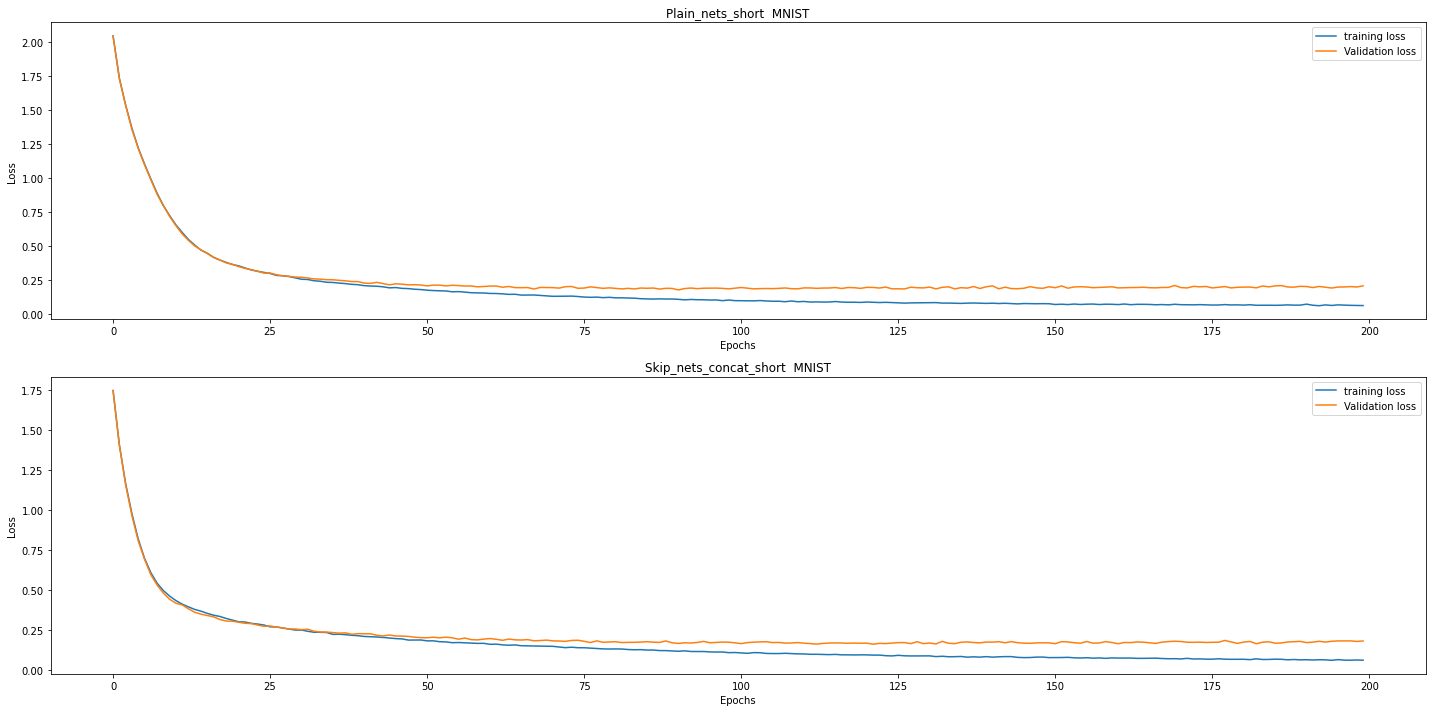

In [9]:

mnist_input_dims = mnist.X_train.shape[1]
dp = 0.2
#instantiating models
plain = Plain_nets_short(mnist_input_dims,dp)
concat = Skip_nets_concat_short(mnist_input_dims,dp) 


PLAIN = Model_Optimizer(mnist,plain,"ADAM",200)
PLAIN.train()
PLAIN.evaluate()


CONCAT = Model_Optimizer(mnist,concat,"ADAM",200)
CONCAT.train()
CONCAT.evaluate()


plot_losses([PLAIN,CONCAT])


del plain,concat,PLAIN,CONCAT
gc.collect()
torch.cuda.empty_cache()

### Performace on CIFAR

Training Plain_nets_short on CIFAR plz wait
Validation accuracy: 0.34119999408721924
Test accuracy: 0.18950000405311584

Training Skip_nets_concat_short on CIFAR plz wait
Validation accuracy: 0.4018000066280365
Test accuracy: 0.24140000343322754



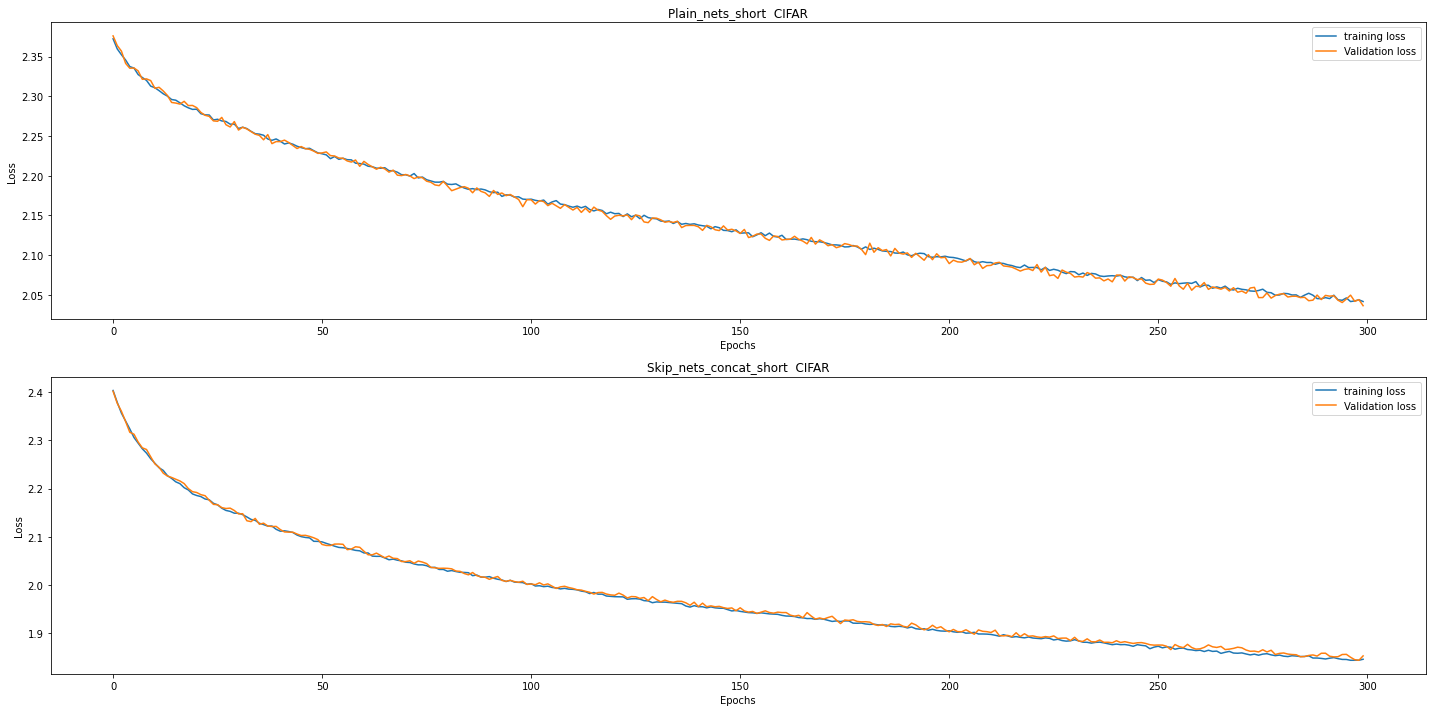

In [10]:
#takes about 20 minutes to complete on cpu
cifar_input_dims = cifar.X_train.shape[1]
dp = 0.3

#instantiating models
plain = Plain_nets_short(cifar_input_dims,dp)
concat = Skip_nets_concat_short(cifar_input_dims,dp) 


PLAIN = Model_Optimizer(cifar,plain,"SGD",300)
PLAIN.train()
PLAIN.evaluate()




CONCAT = Model_Optimizer(cifar,concat,"SGD",300)
CONCAT.train()
CONCAT.evaluate()


plot_losses([PLAIN,CONCAT])


del plain,concat,PLAIN,CONCAT
gc.collect()
torch.cuda.empty_cache()

**Observation**: 
1. Not a lot of  difference in performance which was seen due to the introduction of skip nets in shallow networks for MNIST.

2. Skip nets give a better generalization performance for CIFAR dataset

3. We tried multiple hyperparameters but the validation accuracy never went above 50%



## TASK-2
Compare performace of MLPSs with two different types of Skip Connections

### Performace on MNIST

Training Plain_nets_long on MNIST plz wait
Validation accuracy: 0.5869166851043701
Test accuracy: 0.3905999958515167

Training Skip_nets_add_short on MNIST plz wait
Validation accuracy: 0.8801666498184204
Test accuracy: 0.7407000064849854

Training Skip_nets_concat_short on MNIST plz wait
Validation accuracy: 0.8679166436195374
Test accuracy: 0.8004000186920166



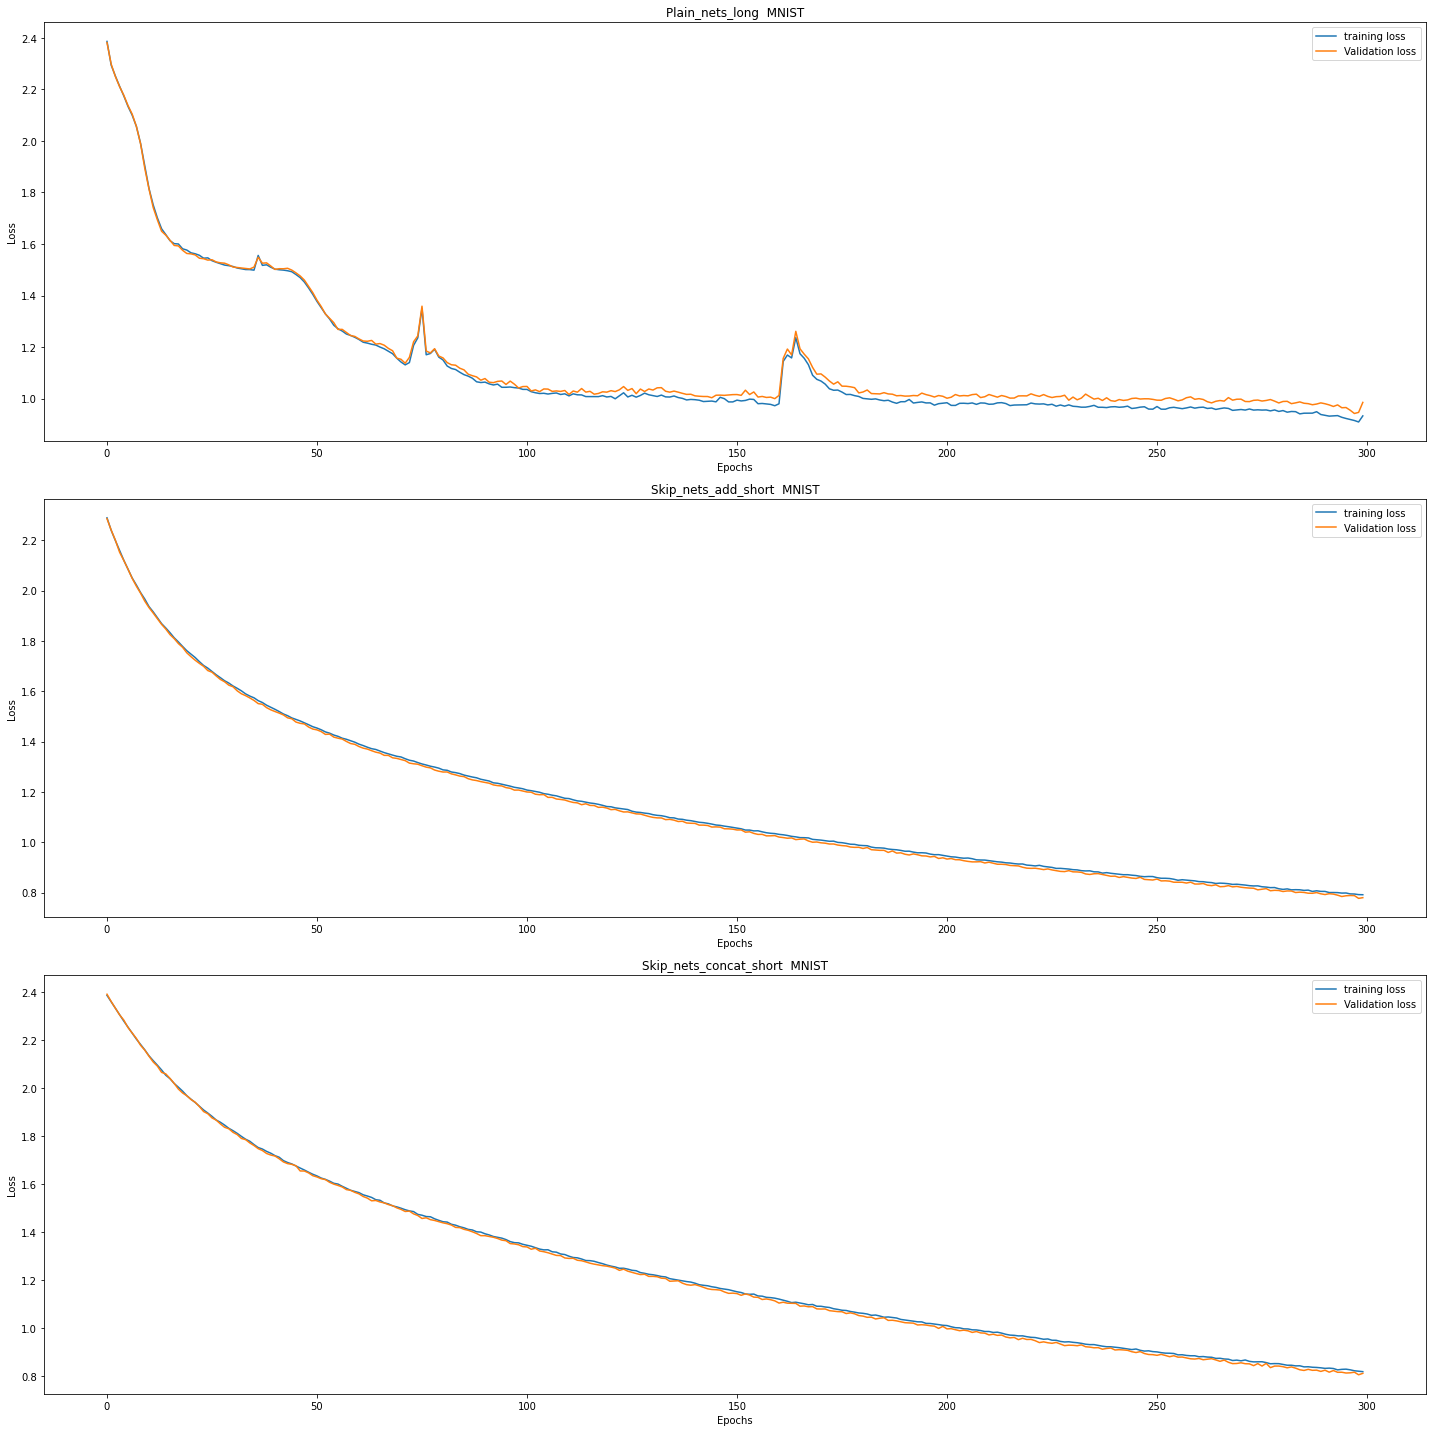

In [24]:
mnist_input_dims = mnist.X_train.shape[1]
dp = 0.3

plain    = Plain_nets_long(mnist_input_dims,dp)
add  =  Skip_nets_add_short(mnist_input_dims,dp)
concat = Skip_nets_concat_short(mnist_input_dims,dp) 


PLAIN = Model_Optimizer(mnist,plain,"ADAM",300)
PLAIN.train()
PLAIN.evaluate()

ADD = Model_Optimizer(mnist,add,"SGD",300)
ADD.train()
ADD.evaluate()


CONCAT = Model_Optimizer(mnist,concat,"SGD",300)
CONCAT.train()
CONCAT.evaluate()

plot_losses([PLAIN,ADD,CONCAT])


del add,concat,ADD,CONCAT,PLAIN
gc.collect()
torch.cuda.empty_cache()


### Performance on CIFAR

Training Plain_nets_long on CIFAR plz wait
Validation accuracy: 0.3472999930381775
Test accuracy: 0.2312999963760376

Training Skip_nets_add_4_14 on CIFAR plz wait
Validation accuracy: 0.4372999966144562
Test accuracy: 0.27549999952316284

Training Skip_nets_concat_4_14 on CIFAR plz wait
Validation accuracy: 0.4047999978065491
Test accuracy: 0.3158999979496002



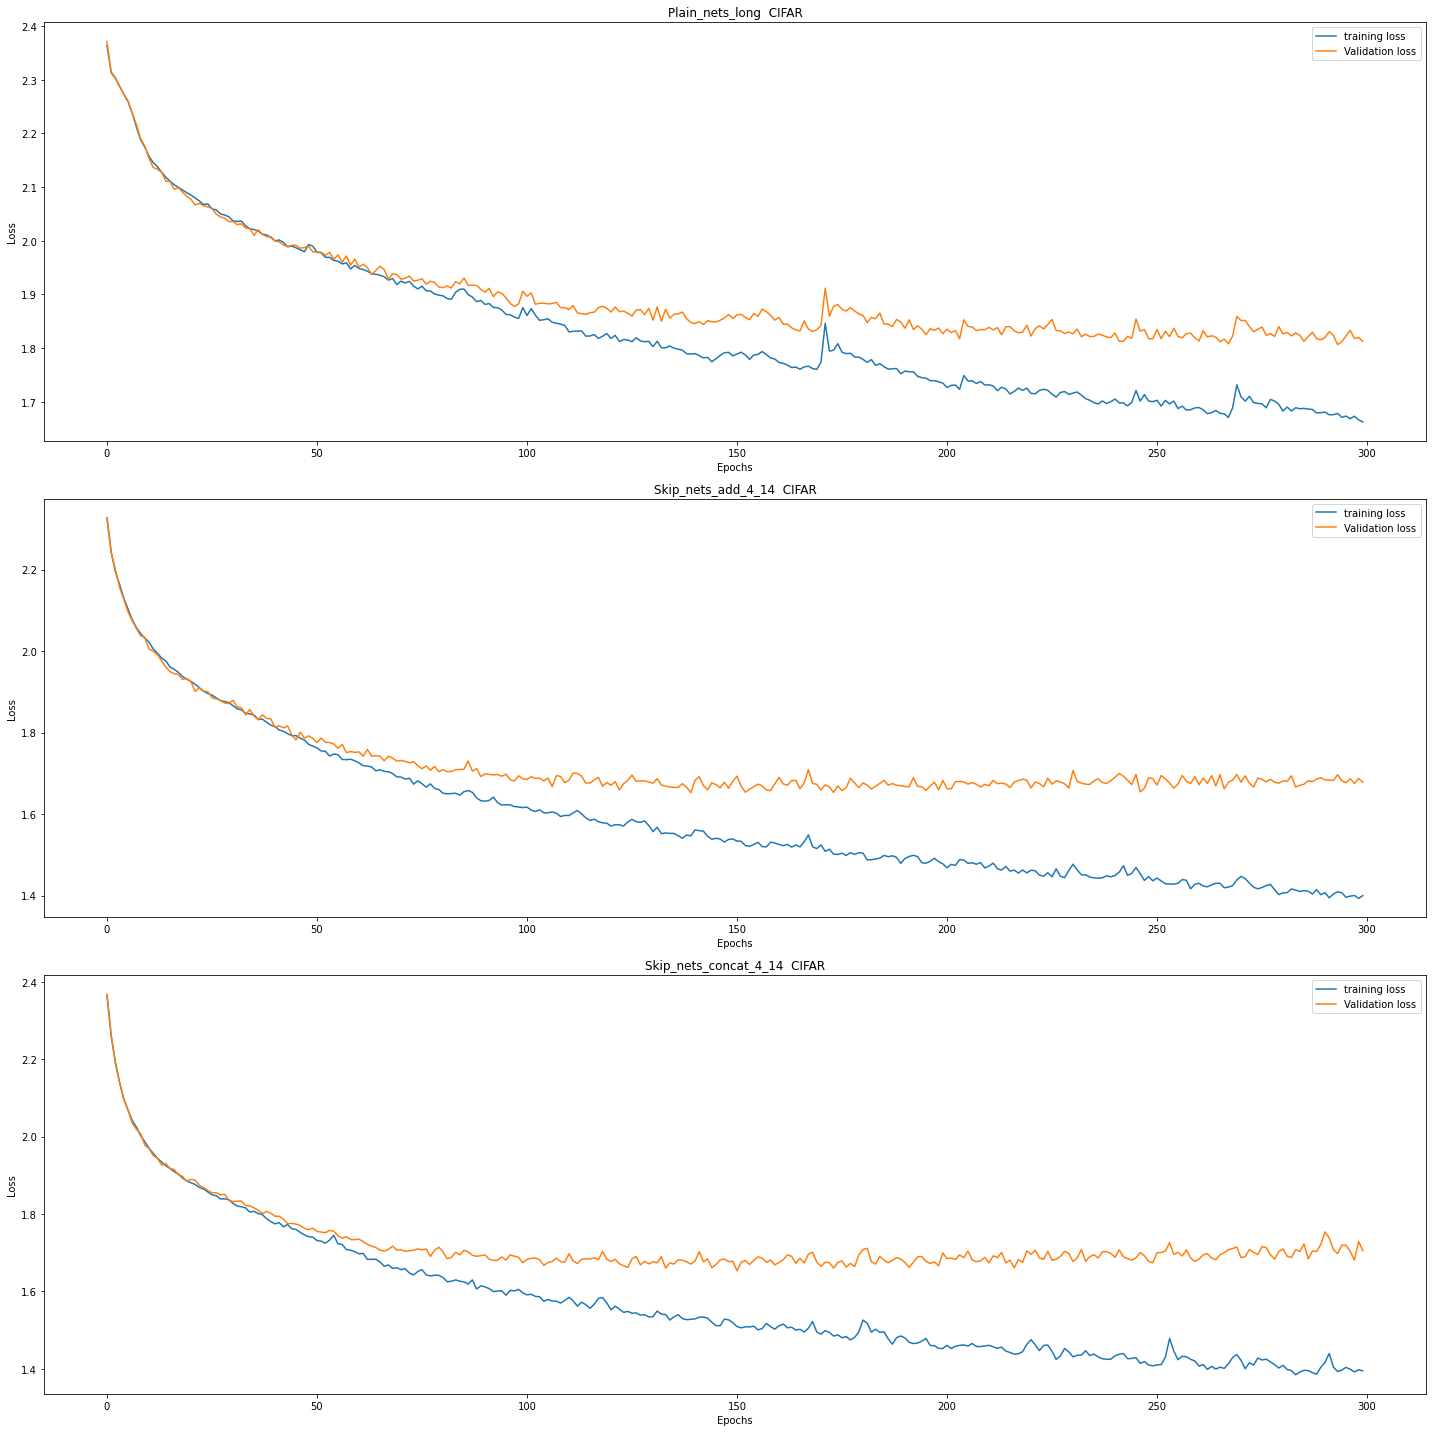

In [25]:
cifar_input_dims = cifar.X_train.shape[1]
dp = 0.3

plain         = Plain_nets_long(cifar_input_dims,dp)
add_4_14      = Skip_nets_add_4_14(cifar_input_dims,dp)
concat_4_14   = Skip_nets_concat_4_14(cifar_input_dims,dp)


PLAIN = Model_Optimizer(cifar,plain,"ADAM",300)
PLAIN.train()
PLAIN.evaluate()

ADD_4_14 = Model_Optimizer(cifar,add_4_14,"ADAM",300)
ADD_4_14.train()
ADD_4_14.evaluate()

CONCAT_4_14 = Model_Optimizer(cifar,concat_4_14,"ADAM",300)
CONCAT_4_14.train()
CONCAT_4_14.evaluate()

plot_losses([PLAIN,ADD_4_14,CONCAT_4_14])


del add_4_14,concat_4_14,ADD_4_14,CONCAT_4_14,PLAIN
gc.collect()
torch.cuda.empty_cache()

**Observations**
1. Both types of Skip connections equally well with marginable differences which can be ignored for both datasets

2. Both type of skip connections muuch better than a plain deep network

3. Skip connections give us a smoother loss curve as compared to plain nets





## TASK-3
Ablation studies

### Difference due to number of layers skipped in skip connections

#### Performance on MNIST

In [14]:
mnist_input_dims = mnist.X_train.shape[1]
dp = 0.3

#instantiating models
plain         = Plain_nets_long(mnist_input_dims,dp)
add_4_14      = Skip_nets_add_4_14(mnist_input_dims,dp)
add_7_14      = Skip_nets_add_7_14(mnist_input_dims,dp)
add_11_14     = Skip_nets_add_11_14(mnist_input_dims,dp)
concat_4_14   = Skip_nets_concat_4_14(mnist_input_dims,dp)
concat_7_14   = Skip_nets_concat_7_14(mnist_input_dims,dp)
concat_11_14  = Skip_nets_concat_11_14(mnist_input_dims,dp)


PLAIN = Model_Optimizer(mnist,plain,"ADAM",300)
PLAIN.train()
PLAIN.evaluate()


ADD_4_14 = Model_Optimizer(mnist,add_4_14,"ADAM",300)
ADD_4_14.train()
ADD_4_14.evaluate()

ADD_7_14 = Model_Optimizer(mnist,add_7_14,"ADAM",300)
ADD_7_14.train()
ADD_7_14.evaluate()

ADD_11_14 = Model_Optimizer(mnist,add_11_14,"ADAM",300)
ADD_11_14.train()
ADD_11_14.evaluate()


CONCAT_4_14 = Model_Optimizer(mnist,concat_4_14,"ADAM",300)
CONCAT_4_14.train()
CONCAT_4_14.evaluate()

CONCAT_7_14 = Model_Optimizer(mnist,concat_7_14,"ADAM",300)
CONCAT_7_14.train()
CONCAT_7_14.evaluate()


CONCAT_11_14 = Model_Optimizer(mnist,concat_11_14,"ADAM",300)
CONCAT_11_14.train()
CONCAT_11_14.evaluate()

Training Plain_nets_long on MNIST plz wait
Validation accuracy: 0.581416666507721
Test accuracy: 0.3817000091075897

Training Skip_nets_add_4_14 on MNIST plz wait
Validation accuracy: 0.9624166488647461
Test accuracy: 0.9311000108718872

Training Skip_nets_add_7_14 on MNIST plz wait
Validation accuracy: 0.9626666903495789
Test accuracy: 0.897599995136261

Training Skip_nets_add_11_14 on MNIST plz wait
Validation accuracy: 0.8129166960716248
Test accuracy: 0.5819000005722046

Training Skip_nets_concat_4_14 on MNIST plz wait
Validation accuracy: 0.9651666879653931
Test accuracy: 0.9229000210762024

Training Skip_nets_concat_7_14 on MNIST plz wait
Validation accuracy: 0.9639999866485596
Test accuracy: 0.8783000111579895

Training Skip_nets_concat_11_14 on MNIST plz wait
Validation accuracy: 0.8690000176429749
Test accuracy: 0.683899998664856



####  Performance on CIFAR

Training Plain_nets_long on CIFAR plz wait
Validation accuracy: 0.1014999970793724
Test accuracy: 0.10000000149011612

Training Skip_nets_add_4_14 on CIFAR plz wait
Validation accuracy: 0.29330000281333923
Test accuracy: 0.16509999334812164

Training Skip_nets_add_7_14 on CIFAR plz wait
Validation accuracy: 0.1462000012397766
Test accuracy: 0.13279999792575836

Training Skip_nets_add_11_14 on CIFAR plz wait
Validation accuracy: 0.10010000318288803
Test accuracy: 0.0989999994635582

Training Skip_nets_concat_4_14 on CIFAR plz wait
Validation accuracy: 0.32359999418258667
Test accuracy: 0.21889999508857727

Training Skip_nets_concat_7_14 on CIFAR plz wait
Validation accuracy: 0.14810000360012054
Test accuracy: 0.10019999742507935

Training Skip_nets_concat_11_14 on CIFAR plz wait
Validation accuracy: 0.10249999910593033
Test accuracy: 0.09989999979734421



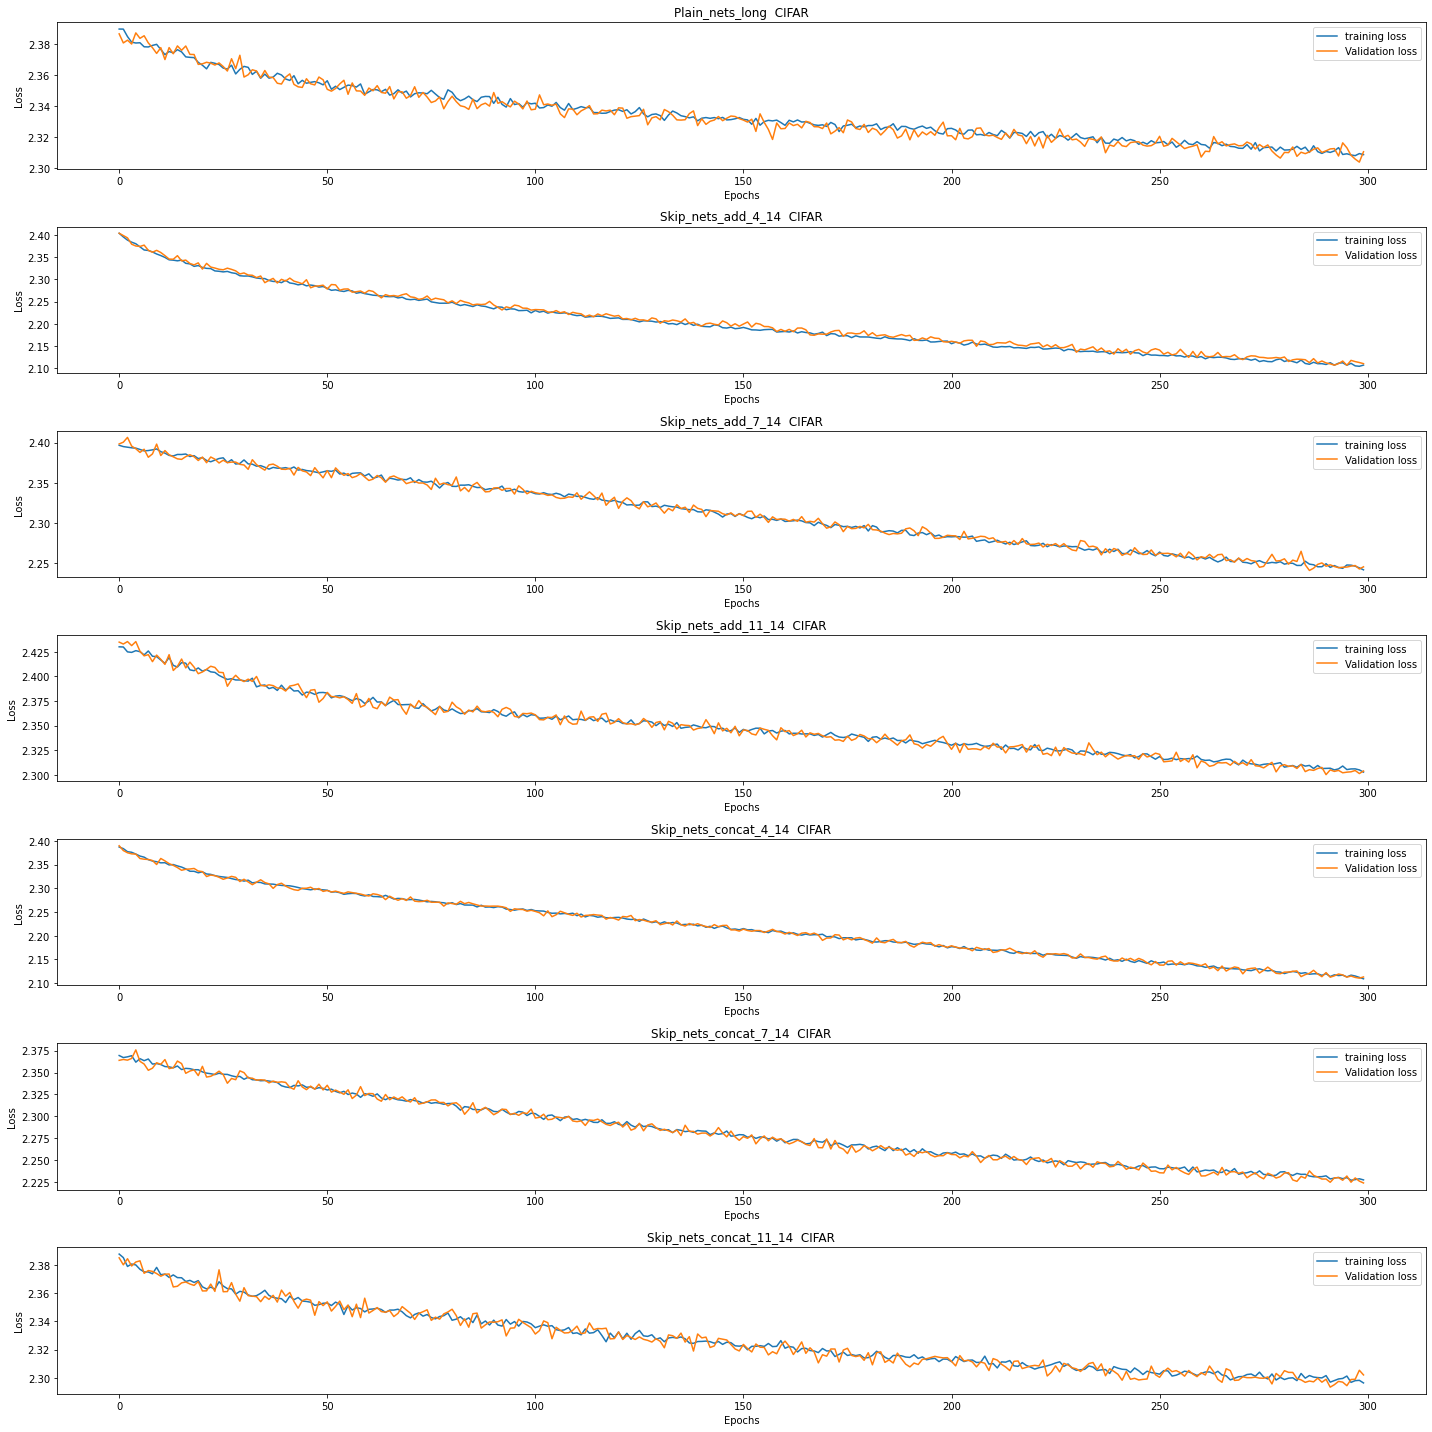

In [21]:
cifar_input_dims = cifar.X_train.shape[1]
dp = 0.3

#instantiating models
plain        = Plain_nets_long(cifar_input_dims,dp)
add_4_14     = Skip_nets_add_4_14(cifar_input_dims,dp)
add_7_14     = Skip_nets_add_7_14(cifar_input_dims,dp)
add_11_14    = Skip_nets_add_11_14(cifar_input_dims,dp)
concat_4_14  = Skip_nets_concat_4_14(cifar_input_dims,dp)
concat_7_14  = Skip_nets_concat_7_14(cifar_input_dims,dp)
concat_11_14 = Skip_nets_concat_11_14(cifar_input_dims,dp)

PLAIN = Model_Optimizer(cifar,plain,"SGD",300)
PLAIN.train()
PLAIN.evaluate()


ADD_4_14 = Model_Optimizer(cifar,add_4_14,"SGD",300)
ADD_4_14.train()
ADD_4_14.evaluate()

ADD_7_14 = Model_Optimizer(cifar,add_7_14,"SGD",300)
ADD_7_14.train()
ADD_7_14.evaluate()

ADD_11_14 = Model_Optimizer(cifar,add_11_14,"SGD",300)
ADD_11_14.train()
ADD_11_14.evaluate()


CONCAT_4_14 = Model_Optimizer(cifar,concat_4_14,"SGD",300)
CONCAT_4_14.train()
CONCAT_4_14.evaluate()

CONCAT_7_14 = Model_Optimizer(cifar,concat_7_14,"SGD",300)
CONCAT_7_14.train()
CONCAT_7_14.evaluate()


CONCAT_11_14 = Model_Optimizer(cifar,concat_11_14,"SGD",300)
CONCAT_11_14.train()
CONCAT_11_14.evaluate()



plot_losses([PLAIN,ADD_4_14,ADD_7_14,ADD_11_14,CONCAT_4_14,CONCAT_7_14,CONCAT_11_14])


del PLAIN,ADD_4_14,ADD_7_14,ADD_11_14,CONCAT_4_14,CONCAT_7_14,CONCAT_11_14,plain,add_4_14,add_7_14,add_11_14,concat_7_14,concat_11_14
gc.collect()
torch.cuda.empty_cache()

**Observations**

1. Skip connections whose number of skipped layers is more give a better performance than those connections where number of layers skipped is less on both datasets

2. Skip connections from shallower layers to deeper layers provide a better performance as they preserve more information from shallower layers (Can be observed in the performance of Skip_nets_<>_4_7 and Skip_nets_<>_11_14)

###  Difference due to number of skip net blocks

#### Performance on MNIST

Training Plain_nets_long on MNIST plz wait
Validation accuracy: 0.7210000157356262
Test accuracy: 0.29010000824928284

Training Skip_nets_add_4_7 on MNIST plz wait
Validation accuracy: 0.7745000123977661
Test accuracy: 0.5670999884605408

Training Skip_nets_add_4_7_11 on MNIST plz wait
Validation accuracy: 0.9613333344459534
Test accuracy: 0.8201000094413757

Training Skip_nets_add_4_7_11_14 on MNIST plz wait
Validation accuracy: 0.9632499814033508
Test accuracy: 0.921999990940094

Training Skip_nets_concat_4_7 on MNIST plz wait
Validation accuracy: 0.8699166774749756
Test accuracy: 0.6970999836921692

Training Skip_nets_concat_4_7_11 on MNIST plz wait
Validation accuracy: 0.9634166955947876
Test accuracy: 0.8269000053405762

Training Skip_nets_concat_4_7_11_14 on MNIST plz wait
Validation accuracy: 0.9628333449363708
Test accuracy: 0.7935000061988831



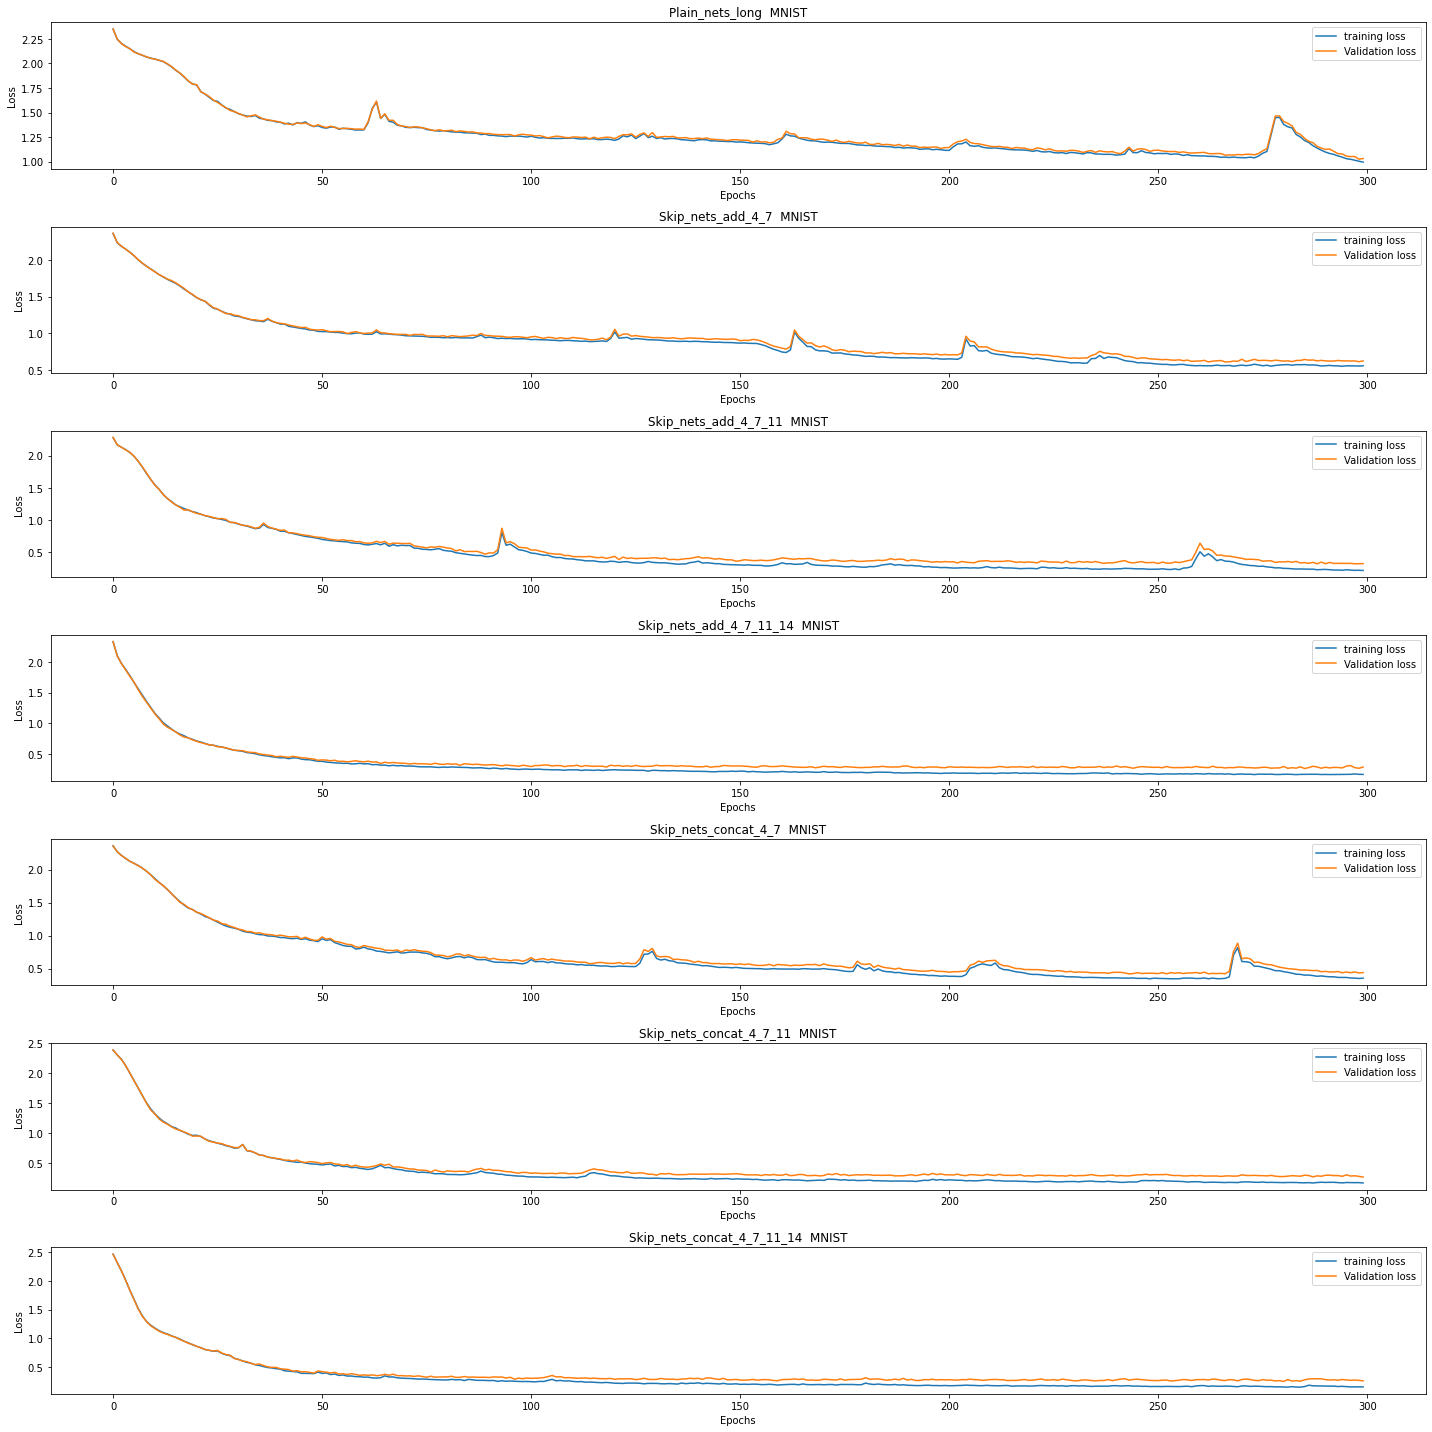

In [22]:
mnist_input_dims = mnist.X_train.shape[1]
dp = 0.3

#instantiating models
plain            = Plain_nets_long(mnist_input_dims,dp)
add_4_7          = Skip_nets_add_4_7(mnist_input_dims,dp)
add_4_7_11       = Skip_nets_add_4_7_11(mnist_input_dims,dp)
add_4_7_11_14    = Skip_nets_add_4_7_11_14(mnist_input_dims,dp)
concat_4_7       = Skip_nets_concat_4_7(mnist_input_dims,dp)
concat_4_7_11    = Skip_nets_concat_4_7_11(mnist_input_dims,dp)
concat_4_7_11_14 = Skip_nets_concat_4_7_11_14(mnist_input_dims,dp)


PLAIN = Model_Optimizer(mnist,plain,"ADAM",300)
PLAIN.train()
PLAIN.evaluate()


ADD_4_7 = Model_Optimizer(mnist,add_4_7,"ADAM",300)
ADD_4_7.train()
ADD_4_7.evaluate()

ADD_4_7_11 = Model_Optimizer(mnist,add_4_7_11,"ADAM",300)
ADD_4_7_11.train()
ADD_4_7_11.evaluate()

ADD_4_7_11_14 = Model_Optimizer(mnist,add_4_7_11_14,"ADAM",300)
ADD_4_7_11_14.train()
ADD_4_7_11_14.evaluate()


CONCAT_4_7 = Model_Optimizer(mnist,concat_4_7,"ADAM",300)
CONCAT_4_7.train()
CONCAT_4_7.evaluate()

CONCAT_4_7_11 = Model_Optimizer(mnist,concat_4_7_11,"ADAM",300)
CONCAT_4_7_11.train()
CONCAT_4_7_11.evaluate()


CONCAT_4_7_11_14 = Model_Optimizer(mnist,concat_4_7_11_14,"ADAM",300)
CONCAT_4_7_11_14.train()
CONCAT_4_7_11_14.evaluate()




plot_losses([PLAIN,ADD_4_7,ADD_4_7_11,ADD_4_7_11_14,CONCAT_4_7,CONCAT_4_7_11,CONCAT_4_7_11_14])


del PLAIN,ADD_4_7,ADD_4_7_11,ADD_4_7_11_14,CONCAT_4_7,CONCAT_4_7_11,CONCAT_4_7_11_14,plain,add_4_7,add_4_7_11,add_4_7_11_14,concat_4_7,concat_4_7_11,concat_4_7_11_14
torch.cuda.empty_cache()




#### Performance on CIFAR

Training Plain_nets_long on CIFAR plz wait
Validation accuracy: 0.3343999981880188
Test accuracy: 0.19269999861717224

Training Skip_nets_add_4_7 on CIFAR plz wait
Validation accuracy: 0.37139999866485596
Test accuracy: 0.2624000012874603

Training Skip_nets_add_4_7_11 on CIFAR plz wait
Validation accuracy: 0.40290001034736633
Test accuracy: 0.2084999978542328

Training Skip_nets_add_4_7_11_14 on CIFAR plz wait
Validation accuracy: 0.3562999963760376
Test accuracy: 0.2809999883174896

Training Skip_nets_concat_4_7 on CIFAR plz wait
Validation accuracy: 0.36719998717308044
Test accuracy: 0.22200000286102295

Training Skip_nets_concat_4_7_11 on CIFAR plz wait
Validation accuracy: 0.37209999561309814
Test accuracy: 0.24459999799728394

Training Skip_nets_concat_4_7_11_14 on CIFAR plz wait
Validation accuracy: 0.4226999878883362
Test accuracy: 0.26100000739097595



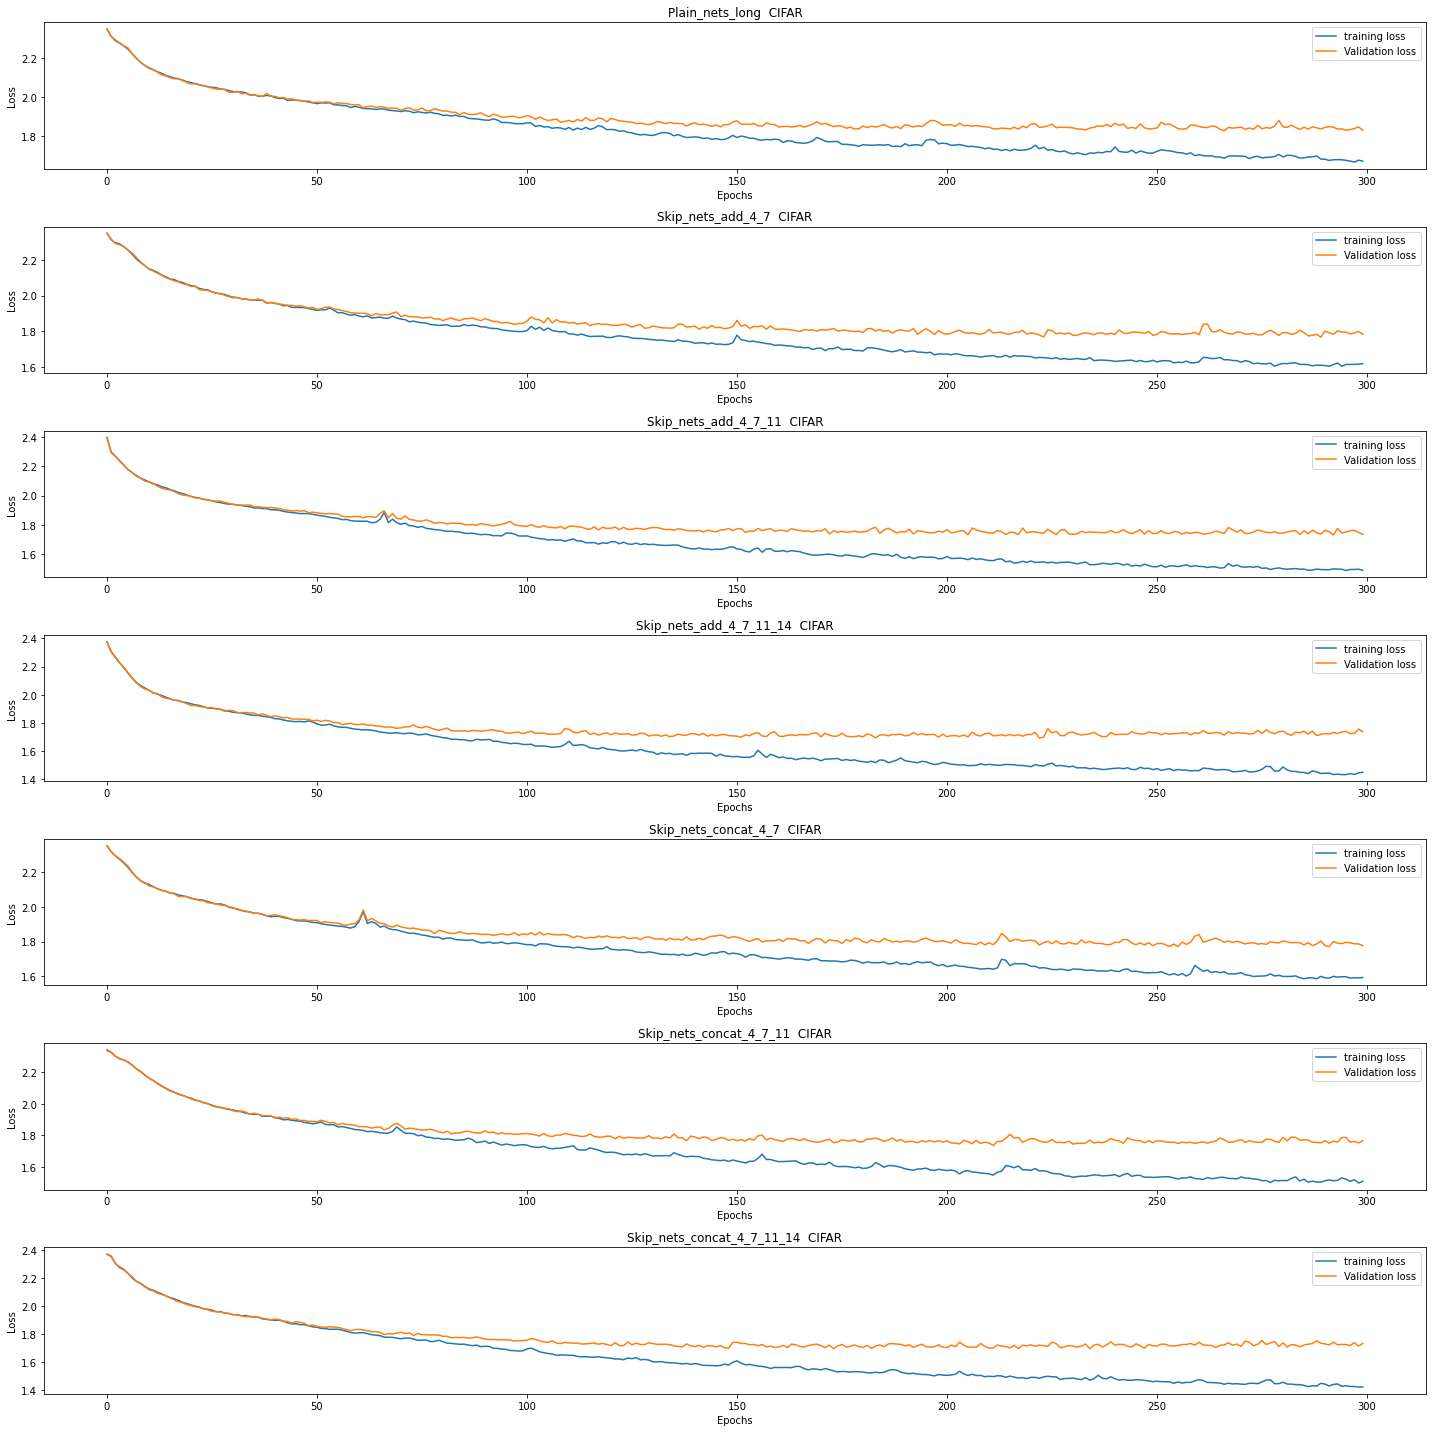

In [23]:
cifar_input_dims = cifar.X_train.shape[1]
dp = 0.3

#instantiating models
plain            = Plain_nets_long(cifar_input_dims,dp)
add_4_7          = Skip_nets_add_4_7(cifar_input_dims,dp)
add_4_7_11       = Skip_nets_add_4_7_11(cifar_input_dims,dp)
add_4_7_11_14    = Skip_nets_add_4_7_11_14(cifar_input_dims,dp)
concat_4_7       = Skip_nets_concat_4_7(cifar_input_dims,dp)
concat_4_7_11    = Skip_nets_concat_4_7_11(cifar_input_dims,dp)
concat_4_7_11_14 = Skip_nets_concat_4_7_11_14(cifar_input_dims,dp)


PLAIN = Model_Optimizer(cifar,plain,"ADAM",300)
PLAIN.train()
PLAIN.evaluate()


ADD_4_7 = Model_Optimizer(cifar,add_4_7,"ADAM",300)
ADD_4_7.train()
ADD_4_7.evaluate()

ADD_4_7_11 = Model_Optimizer(cifar,add_4_7_11,"ADAM",300)
ADD_4_7_11.train()
ADD_4_7_11.evaluate()

ADD_4_7_11_14 = Model_Optimizer(cifar,add_4_7_11_14,"ADAM",300)
ADD_4_7_11_14.train()
ADD_4_7_11_14.evaluate()


CONCAT_4_7 = Model_Optimizer(cifar,concat_4_7,"ADAM",300)
CONCAT_4_7.train()
CONCAT_4_7.evaluate()

CONCAT_4_7_11 = Model_Optimizer(cifar,concat_4_7_11,"ADAM",300)
CONCAT_4_7_11.train()
CONCAT_4_7_11.evaluate()


CONCAT_4_7_11_14 = Model_Optimizer(cifar,concat_4_7_11_14,"ADAM",300)
CONCAT_4_7_11_14.train()
CONCAT_4_7_11_14.evaluate()




plot_losses([PLAIN,ADD_4_7,ADD_4_7_11,ADD_4_7_11_14,CONCAT_4_7,CONCAT_4_7_11,CONCAT_4_7_11_14])


del PLAIN,ADD_4_7,ADD_4_7_11,ADD_4_7_11_14,CONCAT_4_7,CONCAT_4_7_11,CONCAT_4_7_11_14,plain,add_4_7,add_4_7_11,add_4_7_11_14,concat_4_7,concat_4_7_11,concat_4_7_11_14
torch.cuda.empty_cache()

**Observations**

1. More the number of skip connection blocks better is the performance

# TASK-4

We observed that deep MLPs perform worse than those Deep MLP's with skip connections as seen in Task2. So we can say that Skip connections help improve the peformance of deep neural nets by providing a more smoother gradient descent which help us tackle the vanishing gradient problem

# References

1. [Intuitive Explanation of Skip Connections in Deep Learning](https://theaisummer.com/skip-connections/)
2. [Training very deep neural networks: Rethinking the role of skip connections](https://www.sciencedirect.com/science/article/abs/pii/S0925231221002332)
3. [All You Need to Know About Skip Connections](https://www.analyticsvidhya.com/blog/2021/08/all-you-need-to-know-about-skip-connections/)